In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 10000)
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
import matplotlib.pyplot as plt
import os
import transformers
from transformers import BertForTokenClassification, AdamW
from seqeval.metrics import f1_score, accuracy_score
import Levenshtein
import string
import difflib

transformers.__version__

torch.__version__

'1.7.1'

In [3]:
tag_values = ['O', 'PER', 'LOC', 'ORG']
#tag_values = ['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_whole_word_mask=True)
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag2idx), output_attentions = False, output_hidden_states = False)
model.load_state_dict(torch.load("../model/bert_base_conll_capitalization_100.pt", map_location=torch.device('cpu')), strict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

<All keys matched successfully>

In [4]:
def prepare_data_for_test(filepath):
    df = pd.read_csv(filepath)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df = df[:6723]
    g_test = df.groupby("Sentence #")
    test_df = pd.DataFrame({"Sentence": g_test.apply(lambda sdf: " ".join(sdf.Word)),
                       "Tag": g_test.apply(lambda sdf: ",".join(sdf.Tag))})
    test_df.reset_index(inplace=True)
    return df, test_df

In [5]:
def model_test(data, tokenizer, model):
    test = []
    #results = open("conll03_base_ljspeech_asr_test_without_gpe_uncased_results_lower.txt", "a+")
    #test_data=original_data['sentence'].values.tolist()
    #test_data=original_sentence
    #test_data=test_df['Sentence'].values.tolist()
    test_data=data

    # ASR TEST DATE LATEST
    sentence_no = 0
    for data in test_data:
        tokenized_sentence = tokenizer.encode(data.strip())
        #tokenized_sentence = nlp(data.lower().strip())
        input_ids = torch.tensor([tokenized_sentence])
        #input_ids = torch.tensor([tokenized_sentence._.trf_word_pieces])

        with torch.no_grad():
             output = model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        #tokens = _.trf_word_pieces_
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        for token, label in zip(new_tokens, new_labels):
            #result = str(sentence_no) + "\t" + label + "\t" + token + "\n"
            #results.write(result)
            test.append((str(sentence_no), label, token))
        sentence_no = sentence_no + 1
    test_df = pd.DataFrame(test, columns=['sentence_no', 'labels', 'token'])
    return test_df
    #test_df.to_csv("final_asr_test_dataframe.csv", index=False)

In [6]:
def prepare_model_output(test_df, df):
    indexNames = test_df[test_df['token'] == "[CLS]" ].index
    test_df.drop(indexNames, inplace=True)
    indexNames = test_df[test_df['token'] == "[SEP]" ].index
    test_df.drop(indexNames, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    test_df['label_asr'] = df['Tag']
    test_df['token_asr'] = df['Word']
    return test_df

In [7]:
def statistics(test_df, tags):
    new_acc = accuracy_score(test_df['labels'].values.tolist(), test_df['label_asr'].values.tolist())
    print(new_acc)

    new_f1 = f1_score(test_df['labels'].values.tolist(), test_df['label_asr'].values.tolist())
    print(new_f1)
    print("---STATISTICS ON EACH LABEL---")
    for tag in tags:
        true_positive = test_df[((test_df['labels'].str.contains(tag)) & (test_df['label_asr'].str.contains(tag)))]
        print(len(true_positive))
        false_positive = test_df[((test_df['labels'].str.contains(tag)) & (~test_df['label_asr'].str.contains(tag)))]
        print(len(false_positive))
        false_negative = test_df[((~test_df['labels'].str.contains(tag)) & (test_df['label_asr'].str.contains(tag)))]
        print(len(false_negative))
        true_negative = test_df[((~test_df['labels'].str.contains(tag)) & (~test_df['label_asr'].str.contains(tag)))]
        print(len(true_negative))
        prec = len(true_positive) / (len(true_positive) + len(false_positive))
        print(prec)
        recall = len(true_positive) / (len(true_positive) + len(false_negative))
        print(recall)
        f_measure = (2 * prec * recall) / (prec + recall)
        print(f_measure)
        print("---------------------------------------")

In [8]:
df, test_df = prepare_data_for_test('unprocessed_sampled_asr.csv')

In [9]:
df.head()

,Sentence #,Word,Tag
0,2.0,for,O
1,2.0,although,O
2,2.0,the,O
3,2.0,Chinese,O
4,2.0,took,O


In [10]:
test_df.tail()

,Sentence #,Sentence,Tag
371,1693.0,famous female side where the ladies Association still reigned Supreme more system and a greater semblance of decorum was maintained,"O,O,O,O,O,ORG,ORG,O,O,O,O,O,O,O,O,O,O,O,O,O"
372,1705.0,the separation of the Sexes was not in deed rigidly carried out in Newgate as yet,"O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O"
373,1710.0,could also at any time for tea coffee and sugar to Mrs Brown ' s shop which was inside the female gate,"O,O,O,O,O,O,O,O,O,O,O,O,PER,O,O,O,O,O,O,O,O,O"
374,1714.0,some member of the ladies Association observed and commented upon the fact that a young rosy - cheeked girl had been kept by the Governor from transportation,"O,O,O,O,ORG,ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
375,1721.0,committed by the House of Commons who had been lodged in the governor ' s own house,"O,O,O,ORG,ORG,ORG,O,O,O,O,O,O,O,O,O,O,O"


In [11]:
test_df = model_test(test_df['Sentence'].values.tolist(), tokenizer, model)

In [12]:
test_df = prepare_model_output(test_df, df)

In [13]:
test_df.tail(100)

,sentence_no,labels,token,label_asr,token_asr
6623,371,O,side,O,side
6624,371,O,where,O,where
6625,371,O,the,O,the
6626,371,ORG,ladies,ORG,ladies
6627,371,ORG,Association,ORG,Association
6628,371,O,still,O,still
6629,371,O,reigned,O,reigned
6630,371,O,Supreme,O,Supreme
6631,371,O,more,O,more
6632,371,O,system,O,system


In [14]:
test_df['label_asr'].unique()

array(['O', 'LOC', 'PER', 'ORG'], dtype=object)

In [15]:
g_test = test_df.groupby("sentence_no")
test = pd.DataFrame({"model_tag": g_test.apply(lambda sdf: sdf.labels.values.tolist()),
                       "asr_tag": g_test.apply(lambda sdf: sdf.label_asr.values.tolist())})

In [16]:
test['asr_sentence_no'] = test.index
test[["asr_sentence_no"]] = test[["asr_sentence_no"]].apply(pd.to_numeric)
test.sort_values('asr_sentence_no', inplace=True)
test.reset_index(drop=True, inplace=True)

In [17]:
test.head()

,model_tag,asr_tag,asr_sentence_no
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, LOC, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, LOC, O, O, O, O]",0
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, PER, PER, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, LOC, O, PER, PER, O, O, O, O]",1
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, PER]",2
3,"[O, O, O, LOC, O, LOC, ORG, O, O, O]","[O, O, O, LOC, O, LOC, LOC, O, O, O]",3
4,"[O, O, O, O, O, O, LOC, O, O, O, O, O]","[O, O, O, O, O, O, LOC, O, O, O, O, O]",4


In [18]:
print("Accuracy: " , accuracy_score(test['model_tag'].values.tolist(), test['asr_tag'].values.tolist()))
print("F1 Score: ",f1_score(test['model_tag'].values.tolist(), test['asr_tag'].values.tolist()))
#statistics(test_df, ['PER', 'ORG', 'LOC', 'O'])
#0.7758389261744967 without punctuation
#0.676056338028169 with punctuation 1

Accuracy:  0.9476424215380038
F1 Score:  0.7592847317744155


/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [19]:
def prepare_data_for_analysis(test_df, original_data_path):
    g_asr = test_df.groupby("sentence_no")
    asr_df = pd.DataFrame({'Sentence': g_asr.apply(lambda sdf: " ".join(map(str,sdf.token))),
                      'Tag': g_asr.apply(lambda sdf: ",".join(sdf.labels))})
    asr_df['asr_sentence_no'] = asr_df.index
    asr_df[["asr_sentence_no"]] = asr_df[["asr_sentence_no"]].apply(pd.to_numeric)
    asr_df.sort_values('asr_sentence_no', inplace=True)
    asr_df.reset_index(drop=True, inplace=True)
    original = pd.read_csv(original_data_path)
    original.drop(['Unnamed: 0'], axis=1, inplace=True)
    original = original[:7851]
    g_original = original.groupby("Sentence #")
    original_df = pd.DataFrame({'Sentence': g_original.apply(lambda sdf: " ".join(map(str,sdf.Word))),
                      'Tag': g_original.apply(lambda sdf: ",".join(sdf.Tag))})
    original_df.reset_index(inplace=True)
    combined_df = pd.DataFrame({"original_sentence": original_df['Sentence'],
                           "original_tags": original_df['Tag'], 
                           "asr_sentence": asr_df['Sentence'],
                           "asr_tags": asr_df['Tag']})
    return asr_df, combined_df

In [20]:
def pattern_finding(tag, combined_df):
#tag = "PER"
    analysis = []
    for i in range(0, len(combined_df), 1):
        sample = combined_df.loc[[i]]
        for original_sentence, asr_sentence, original_tag, asr_tag in zip(sample['original_sentence'].values.tolist(),
                                                                          sample['asr_sentence'].values.tolist(),
                                                                          sample['original_tags'].values.tolist(),
                                                                          sample['asr_tags'].values.tolist()):
            original_tag_token = np.array(original_tag.split(","))
            asr_tag_token = np.array(asr_tag.split(","))
            original_label = np.array(original_sentence.split())
            asr_label = np.array(asr_sentence.split())

            if tag in original_tag_token:
                original_tag_ind = [index for index, element in enumerate(original_tag_token) if
                                    original_tag_token[index] == tag]
                if tag in asr_tag_token:
                    asr_tag_ind = [index for index, element in enumerate(asr_tag_token) if
                                       asr_tag_token[index] == tag]
                    
                    asr_tokens = []
                    original_tokens = []
                    errors = []
                        # Sweynheim pannartz
                        # Swain heim pannartz
                    for ind in original_tag_ind:
                        original_entity = original_label[ind]
                        asr_entity = difflib.get_close_matches(original_entity, asr_label[asr_tag_ind])
                        if len(asr_entity) > 0:
                            asr_entity = asr_entity[0]
                            error = (1 - (Levenshtein.distance(original_entity, asr_entity) / max(len(original_entity), len(asr_entity)))) * 100
                            if error >= 50:
                                asr_tokens.append(asr_entity)
                                original_tokens.append(original_entity)
                                errors.append(error)
                            else:
                                asr_tokens.append("None")
                                original_tokens.append(original_entity)
                                errors.append(0.0)
                        else:
                            asr_tokens.append("None")
                            original_tokens.append(original_entity)
                            errors.append(0.0)
                    analysis.append((i, original_tokens, asr_tokens, errors, np.mean(errors), True))
                else:
                    check = []
                    o_label = original_label[original_tag_ind]
                    for lab in o_label:
                        j = 0
                        for asr_lab in asr_label:
                            local_error = (1 - (Levenshtein.distance(lab, asr_lab) / max(len(lab), len(asr_lab)))) * 100
                            if local_error >= 50.0:
                                check.append(j)
                            j = j + 1
                    if len(check) > 0:
                        asr_tokens = []
                        original_tokens = []
                        errors = []
                        for ind in original_tag_ind:
                            original_entity = original_label[ind]
                            asr_entity = difflib.get_close_matches(original_entity, asr_label[check])
                            if len(asr_entity) > 0:
                                asr_entity = asr_entity[0]
                                error = (1 - (Levenshtein.distance(original_entity, asr_entity) / max(
                                len(original_entity), len(asr_entity)))) * 100
                                asr_tokens.append(asr_entity)
                                original_tokens.append(original_entity)
                                errors.append(error)
                            else:
                                asr_tokens.append("None")
                                original_tokens.append(original_entity)
                                errors.append(0.0)
                        analysis.append((i, original_tokens, asr_tokens, errors, np.mean(errors), False))
                    else:
                        analysis.append((i, original_label[original_tag_ind], ["None"], [0.0], 0.0, False))
    return analysis

In [21]:
test_df.head()

,sentence_no,labels,token,label_asr,token_asr
0,0,O,for,O,for
1,0,O,although,O,although
2,0,O,the,O,the
3,0,O,Chinese,O,Chinese
4,0,O,took,O,took


In [22]:
asr_df, combined_df = prepare_data_for_analysis(test_df, 'unprocessed_sampled_original.csv')

In [135]:
original = pd.read_csv('unprocessed_sampled_original.csv')
original.drop(['Unnamed: 0'], axis=1, inplace=True)
original = original[:7851]
g_original = original.groupby("Sentence #")
original_df = pd.DataFrame({'Sentence': g_original.apply(lambda sdf: " ".join(map(str,sdf.Word))),
                      'Tag': g_original.apply(lambda sdf: ",".join(sdf.Tag))})
original_df.reset_index(inplace=True)
combined_df = pd.DataFrame({"original_sentence": original_df['Sentence'],
                           "original_tags": original_df['Tag'], 
                           "asr_sentence": asr_df['Sentence'],
                           "asr_tags": asr_df['Tag']})

In [136]:
analysis_df = pd.DataFrame(pattern_finding("ORG", combined_df), columns=['Sample #', 'Original', 'ASR', 'Lavenstein', 'Lavenstein Mean', 'Flag'])

In [137]:
analysis_df.head(10)

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,11,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
1,25,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
2,27,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
3,37,[Chiswick],[Chiswick],[100.0],100.000000,False
4,49,[Society],[society],[85.71428571428572],85.714286,False
5,50,"[Chronicles, of, Newgate]","[Chronicles, of, NewNewgate]","[100.0, 100.0, 70.0]",90.000000,False
6,58,"[Court, of, Common, Council]","[None, None, common, Council]","[0.0, 0.0, 83.33333333333334, 100.0]",45.833333,True
7,59,"[House, of, Commons]","[House, of, Commons]","[100.0, 100.0, 100.0]",100.000000,True
8,62,"[State, of, Prisons]","[state, of, prisons]","[80.0, 100.0, 85.71428571428572]",88.571429,False
9,72,"[Court, Baron, Hundred, Court, County, Court]","[court, Baron, hundred, court, county, court]","[80.0, 100.0, 85.71428571428572, 80.0, 83.33333333333334, 80.0]",84.841270,False


In [138]:
len(analysis_df)

125

In [139]:
len(combined_df)

376

In [140]:
np.mean([100.0,100.0]) == 100.0

True

In [141]:
orig_asr_found_complete = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] == 100.0)]
orig_asr_found_complete_per = (len(orig_asr_found_complete) / len(analysis_df)) * 100
print(orig_asr_found_complete_per)
orig_asr_found_complete.head()
print(len(orig_asr_found_complete))

13.600000000000001
17


In [142]:
orig_asr_found_complete.head()

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
7,59,"[House, of, Commons]","[House, of, Commons]","[100.0, 100.0, 100.0]",100.0,True
10,73,"[County, Court]","[County, Court]","[100.0, 100.0]",100.0,True
23,106,"[Star, Chamber]","[Star, Chamber]","[100.0, 100.0]",100.0,True
25,109,"[House, of, Commons]","[House, of, Commons]","[100.0, 100.0, 100.0]",100.0,True
43,155,[Newgate],[Newgate],[100.0],100.0,True


In [143]:
orig_asr_found = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] < 100.0) & (analysis_df['Lavenstein Mean'] >= 0.0)]
orig_asr_found_per = (len(orig_asr_found) / len(analysis_df)) * 100
print(orig_asr_found_per)
print(len(orig_asr_found))
orig_asr_found.head()
#40.88050314465409
#65

20.8
26


,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
6,58,"[Court, of, Common, Council]","[None, None, common, Council]","[0.0, 0.0, 83.33333333333334, 100.0]",45.833333,True
11,74,"[Court, of, King, ', s, Bench]","[Court, of, King, ', s, None]","[100.0, 100.0, 100.0, 100.0, 100.0, 0.0]",83.333333,True
19,99,"[King, ', s, Bench, King, ', s, Bench]","[Kings, None, None, None, Kings, None, None, None]","[80.0, 0.0, 0.0, 0.0, 80.0, 0.0, 0.0, 0.0]",20.000000,True
28,119,"[Courts, of, Conscience]","[Courts, of, conscience]","[100.0, 100.0, 90.0]",96.666667,True
29,120,"[King, ', s, Bench]","[Kings, None, None, None]","[80.0, 0.0, 0.0, 0.0]",20.000000,True


In [144]:
#combined_df.loc[orig_asr_found['Sample #'].values.tolist()]

In [145]:
orig_asr_similar = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 100.0) & (analysis_df['Lavenstein Mean'] > 0.0)]
orig_asr_similar_per = (len(orig_asr_similar) / len(analysis_df)) * 100
print(orig_asr_similar_per)
orig_asr_similar.head()
print(len(orig_asr_similar))

62.4
78


In [146]:
orig_asr_similar.head()

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,11,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
1,25,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
2,27,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
3,37,[Chiswick],[Chiswick],[100.0],100.000000,False
4,49,[Society],[society],[85.71428571428572],85.714286,False


In [147]:
orig_asr_nofound = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 0.0)]
orig_asr_nofound_per = (len(orig_asr_nofound) / len(analysis_df))*100
print(orig_asr_nofound_per)
orig_asr_nofound.head()
print(len(orig_asr_nofound))

3.2
4


In [148]:
orig_asr_nofound.head()

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
53,200,[Newgate],[None],[0.0],0.0,False
63,247,[Newgate],[None],[0.0],0.0,False
91,295,[Society],[None],[0.0],0.0,False
92,296,[Society],[None],[0.0],0.0,False


In [149]:
[orig_asr_found_complete_per, orig_asr_found_per, orig_asr_similar_per, orig_asr_nofound_per]

[13.600000000000001, 20.8, 62.4, 3.2]

In [150]:
[len(orig_asr_found_complete), len(orig_asr_found), len(orig_asr_similar), len(orig_asr_nofound)]

[17, 26, 78, 4]

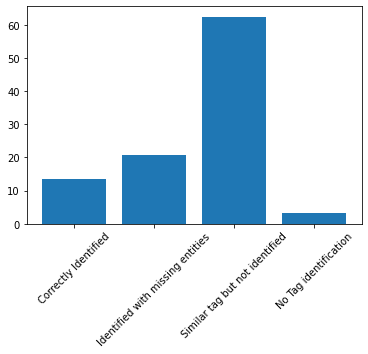

In [151]:
#!/usr/bin/python3
import matplotlib.pyplot as plt

data = [orig_asr_found_complete_per, orig_asr_found_per, orig_asr_similar_per, orig_asr_nofound_per]
plt.bar(['Correctly Identified', 'Identified with missing entities', 'Similar tag but not identified', 'No Tag identification'], data)
plt.xticks(rotation=45)
plt.show()

In [152]:
def pattern_analysis(sample_df, combined_df):
    ind = np.array(sample_df['Sample #'].values.tolist())
    df = combined_df.loc[ind]
    df.insert(2,'Original',sample_df['Original'].values.tolist())
    df.insert(5,'ASR',sample_df['ASR'].values.tolist())
    df.drop(['original_tags', 'asr_tags'], axis=1, inplace=True)
    df.head(50)
    return df

In [153]:
error_pattern = pattern_analysis(orig_asr_similar, combined_df)

In [154]:
len(error_pattern)

78

In [155]:
error_pattern.head(10)

,original_sentence,Original,asr_sentence,ASR
11,"It must be said that it is in no way like the transition type of Subiaco ,",[Subiaco],it must be said that it is in no way like the transition type of subiaco,[subiaco]
25,"many of whose types , indeed , like that of the Subiaco works , are of a transitional character .",[Subiaco],many of whose types indeed like that of the subiaco works are of a transitional character,[subiaco]
27,In fact Gunther Zeiner ' s first type ( afterwards used by Schussler ) is remarkably like the type of the before - mentioned Subiaco books .,[Subiaco],in fact Gunther ' s designers first type afterwards used by schussler is remarkably like the type of the before mentioned subiaco books,[subiaco]
37,"The Chiswick press in 1844 revived Caslon ' s founts , printing for Messrs . Longman the Diary of Lady Willoughby .",[Chiswick],Chiswick press in 1844 revived Castle on stops printing for measures the Diary of Lady Willoughby,[Chiswick]
49,"the position of our Society that a work of utility might be also a work of art , if we cared to make it so .",[Society],the position of our society that don ' t work of utility might be also a work of art if we care to make it so,[society]
50,"The Chronicles of Newgate , Volume 2 . By Arthur Griffiths . Section 4 : Newgate Newgate down to 1818 .","[Chronicles, of, Newgate]",The Chronicles of nougat volume to Arthur Griffiths section for new NewNewgate down to 1818,"[Chronicles, of, NewNewgate]"
62,"Full details of the arrangements are to be found in Mr . Neild ' s "" State of Prisons in England , Scotland , and Wales , "" published in 1812 .","[State, of, Prisons]",full details of the arrangements are to be found in Mr Neil ' s state of prisons in England Scotland and Wales published in 1812,"[state, of, prisons]"
72,"Alfred the Great established the Court Baron , the Hundred Court , and the County Court , which among other matters entertained pleas for debt .","[Court, Baron, Hundred, Court, County, Court]",Alfred the Great established the court Baron the hundred court and the county court which among other matters entertain please for debt,"[court, Baron, hundred, court, county, court]"
75,"So much inconvenience ensued , that in 1518 the Corporation obtained from Parliament an act empowering two aldermen","[Corporation, Parliament]",so much inconvenience ensued that in 1518 the corporation obtained from Parliament and act empowering to alderman,"[corporation, Parliament]"
76,"and four common councilmen to hold Courts of Requests , or Courts of Conscience , to hear and determine all causes of debt","[Courts, of, Requests, Courts, of, Conscience, of]",four common councilman to hold courts of requests or courts of conscience to hear and determine all causes of death,"[courts, of, requests, courts, of, conscience, of]"


In [156]:
def error_sampling(df):
    i = 0
    equal_length_samples = []
    variable_length_samples = []
    for sample, original, asr in zip(df.index, 
                                     df['Original'],
                                     df['ASR']):
        if len(original) == len(asr):
            equal_length_samples.append(sample)
        else:
            variable_length_samples.append(sample)
    equal_length_samples.sort()
    variable_length_samples.sort()
    equal_length_samples_df = df.loc[equal_length_samples]
    variable_length_samples_df = df.loc[variable_length_samples]
    return equal_length_samples_df, variable_length_samples_df

In [157]:
equal_length_words_samples_df, variable_length_words_samples_df = error_sampling(error_pattern)

In [158]:
len(equal_length_words_samples_df)

78

In [159]:
equal_length_words_samples_df.head(40)

,original_sentence,Original,asr_sentence,ASR
11,"It must be said that it is in no way like the transition type of Subiaco ,",[Subiaco],it must be said that it is in no way like the transition type of subiaco,[subiaco]
25,"many of whose types , indeed , like that of the Subiaco works , are of a transitional character .",[Subiaco],many of whose types indeed like that of the subiaco works are of a transitional character,[subiaco]
27,In fact Gunther Zeiner ' s first type ( afterwards used by Schussler ) is remarkably like the type of the before - mentioned Subiaco books .,[Subiaco],in fact Gunther ' s designers first type afterwards used by schussler is remarkably like the type of the before mentioned subiaco books,[subiaco]
37,"The Chiswick press in 1844 revived Caslon ' s founts , printing for Messrs . Longman the Diary of Lady Willoughby .",[Chiswick],Chiswick press in 1844 revived Castle on stops printing for measures the Diary of Lady Willoughby,[Chiswick]
49,"the position of our Society that a work of utility might be also a work of art , if we cared to make it so .",[Society],the position of our society that don ' t work of utility might be also a work of art if we care to make it so,[society]
50,"The Chronicles of Newgate , Volume 2 . By Arthur Griffiths . Section 4 : Newgate Newgate down to 1818 .","[Chronicles, of, Newgate]",The Chronicles of nougat volume to Arthur Griffiths section for new NewNewgate down to 1818,"[Chronicles, of, NewNewgate]"
62,"Full details of the arrangements are to be found in Mr . Neild ' s "" State of Prisons in England , Scotland , and Wales , "" published in 1812 .","[State, of, Prisons]",full details of the arrangements are to be found in Mr Neil ' s state of prisons in England Scotland and Wales published in 1812,"[state, of, prisons]"
72,"Alfred the Great established the Court Baron , the Hundred Court , and the County Court , which among other matters entertained pleas for debt .","[Court, Baron, Hundred, Court, County, Court]",Alfred the Great established the court Baron the hundred court and the county court which among other matters entertain please for debt,"[court, Baron, hundred, court, county, court]"
75,"So much inconvenience ensued , that in 1518 the Corporation obtained from Parliament an act empowering two aldermen","[Corporation, Parliament]",so much inconvenience ensued that in 1518 the corporation obtained from Parliament and act empowering to alderman,"[corporation, Parliament]"
76,"and four common councilmen to hold Courts of Requests , or Courts of Conscience , to hear and determine all causes of debt","[Courts, of, Requests, Courts, of, Conscience, of]",four common councilman to hold courts of requests or courts of conscience to hear and determine all causes of death,"[courts, of, requests, courts, of, conscience, of]"


In [160]:
len(variable_length_words_samples_df)

0

In [161]:
variable_length_words_samples_df.head(10)

,original_sentence,Original,asr_sentence,ASR


In [162]:
def equal_words_simulation(sampled_df):
    simulated_asr = []
    for sample, original_sentence, asr_sentence, original, asr in zip(sampled_df.index,
                                     sampled_df['original_sentence'],
                                     sampled_df['asr_sentence'],
                                     sampled_df['Original'],
                                     sampled_df['ASR']):

        for x,y in zip(original, asr):
            #original_words.append(x)
            #asr_words.append(y)
            if y in asr_sentence:
                asr_sentence = asr_sentence.replace(y, x)
            
        simulated_asr.append((sample, asr_sentence))
    simulated_asr_df = pd.DataFrame(simulated_asr)
    return simulated_asr_df

In [163]:
def variable_words_simulation(df):
    check = []
    for sample, original_sentence, asr_sentence, original_tag, asr_tag in zip(
            df.index,
            df['original_sentence'].values.tolist(),
            df['asr_sentence'].values.tolist(),
            df['Original'].values.tolist(),
            df['ASR'].values.tolist()):

        original_label = np.array(original_sentence.split())
        asr_label = np.array(asr_sentence.split())
        original_tag_ind = [index for index, element in enumerate(original_label) if original_label[index] in original_tag]
        asr_tag_ind = [index for index, element in enumerate(asr_label) if asr_label[index] in asr_tag]
        original_bigrams = []
        asr_bigrams = []
        o_label = original_label[original_tag_ind]
        for lab in original_tag:
            for asr_lab in asr_tag:
                local_error = (1 - (Levenshtein.distance(lab, asr_lab) / max(len(lab), len(asr_lab)))) * 100
                if local_error >= 50.0:
                    asr_sentence = asr_sentence.replace(asr_lab, lab)
        check.append((sample, asr_sentence))
    new_asr = pd.DataFrame(check)
    return new_asr

In [164]:
def update_df(asr_df, simulated_df):
    asr_df.loc[simulated_df[0].values.tolist(), 'Sentence'] = simulated_df[1].values.tolist()
    return asr_df

In [165]:
simulated_asr_df = equal_words_simulation(equal_length_words_samples_df)

In [166]:
simulated_asr_df.head()

,0,1
0,11,it must be said that it is in no way like the transition type of Subiaco
1,25,many of whose types indeed like that of the Subiaco works are of a transitional character
2,27,in fact Gunther ' s designers first type afterwards used by schussler is remarkably like the type of the before mentioned Subiaco books
3,37,Chiswick press in 1844 revived Castle on stops printing for measures the Diary of Lady Willoughby
4,49,the position of our Society that don ' t work of utility might be also a work of art if we care to make it so


In [167]:
asr_df = update_df(asr_df, simulated_asr_df)

In [168]:
asr_df.head(50)

,Sentence,Tag,asr_sentence_no
0,for although the Chinese took Impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands by a similar process,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O",0
1,what the first Bible actually dated which also was printed at mace by Peter Shaffer in the year 1462,"O,O,O,O,O,O,O,O,O,O,O,O,O,PER,PER,O,O,O,O",1
2,especially as regards to lowercase letters and type very similar was used during the next 15 or 20 years not only by Schoeffer,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O",2
3,Buy printers in Strasburg basil Paris Lubec and other cities,"O,O,O,LOC,O,LOC,ORG,O,O,O",3
4,but don ' t expect in Italy letter with most often used,"O,O,O,O,O,O,LOC,O,O,O,O,O",4
5,a very few years saw the birth of Roman character not only in Italy but in Germany and France,"O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,LOC,O,LOC",5
6,1465 Swain Haim and pennartz began printing in the monastery of subiaco near Rome,"O,PER,PER,O,O,O,O,O,O,O,O,LOC,O,LOC",6
7,printed very few books in this type 3 only but in their very first book syndrome beginning with the year 1468,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O",7
8,about the same year mental in at Strasburg began to print in a type which is distinctly Roman,"O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,O,O,O",8
9,and the next year Gunther ' s designer at Augsburg followed suit,"O,O,O,O,PER,O,O,O,O,LOC,O,O",9


In [169]:
#simulated_asr_df = variable_words_simulation(variable_length_words_samples_df)
#simulated_asr_df.head()

In [170]:
#asr_df = update_df(asr_df, simulated_asr_df)

In [171]:
test_df = model_test(asr_df['Sentence'].values.tolist(), tokenizer, model)

In [172]:
#test_df = prepare_model_output(test_df, new_df)
test_df = prepare_model_output(test_df, df)

In [173]:
test_df.tail()

,sentence_no,labels,token,label_asr,token_asr
6718,375,O,governor,O,governor
6719,375,O,',O,'
6720,375,O,s,O,s
6721,375,O,own,O,own
6722,375,O,house,O,house


In [174]:
g_test = test_df.groupby("sentence_no")
test = pd.DataFrame({"model_tag": g_test.apply(lambda sdf: sdf.labels.values.tolist()),
                       "asr_tag": g_test.apply(lambda sdf: sdf.label_asr.values.tolist())})
test['asr_sentence_no'] = test.index
test[["asr_sentence_no"]] = test[["asr_sentence_no"]].apply(pd.to_numeric)
test.sort_values('asr_sentence_no', inplace=True)
test.reset_index(drop=True, inplace=True)

#statistics(test_df, ['PER', 'ORG', 'LOC', 'O'])
#0.7758389261744967 without punctuation
#0.676056338028169 with punctuation 1

In [176]:
test.tail()

,model_tag,asr_tag,asr_sentence_no
371,"[O, O, O, O, O, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O]",371
372,"[O, O, O, O, O, O, O, O, O, O, O, O, O, LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, LOC, O, O]",372
373,"[O, O, O, O, O, O, O, O, O, O, O, O, PER, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, PER, O, O, O, O, O, O, O, O, O]",373
374,"[O, O, O, O, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",374
375,"[O, O, O, ORG, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, ORG, ORG, ORG, O, O, O, O, O, O, O, O, O, O, O]",375


In [177]:
print("Accuracy: " , accuracy_score(test['model_tag'].values.tolist(), test['asr_tag'].values.tolist()))
print("F1 Score: ",f1_score(test['model_tag'].values.tolist(), test['asr_tag'].values.tolist()))

Accuracy:  0.9611780455153949
F1 Score:  0.772845953002611


/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [178]:
asr_df, combined_df = prepare_data_for_analysis(test_df, 'unprocessed_sampled_original.csv')

In [215]:
analysis_df = pd.DataFrame(pattern_finding("PER", combined_df), columns=['Sample #', 'Original', 'ASR', 'Lavenstein','Lavenstein Mean', 'Flag'])

In [216]:
analysis_df.head(10)

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,1,"[Peter, Schoeffer]","[Peter, Shaffer]","[100.0, 66.66666666666667]",83.333333,True
1,2,[Schoeffer],[Schoeffer],[100.0],100.000000,True
2,6,"[Sweynheim, Pannartz]","[None, None]","[0.0, 0.0]",0.000000,True
3,8,[Mentelin],[None],[0.0],0.000000,False
4,9,"[Gunther, Zeiner]","[Gunther, None]","[100.0, 0.0]",50.000000,True
5,10,"[Udalric, Gering]",[None],[0.0],0.000000,False
6,14,"[John, Vindelin, Nicholas, Jenson]","[John, None, None, None]","[100.0, 0.0, 0.0, 0.0]",25.000000,True
7,15,[Jenson],[Jensen],[83.33333333333334],83.333333,True
8,17,[Aldus],[Aldis],[80.0],80.000000,True
9,18,[Jenson],[Jensen],[83.33333333333334],83.333333,True


In [217]:
len(analysis_df)

158

In [218]:
len(combined_df)

376

In [219]:
orig_asr_found_complete = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] == 100.0)]
orig_asr_found_complete_per = (len(orig_asr_found_complete) / len(analysis_df)) * 100
print(orig_asr_found_complete_per)
orig_asr_found_complete.head()
print(len(orig_asr_found_complete))

39.87341772151899
63


In [220]:
orig_asr_found = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] < 100.0) & (analysis_df['Lavenstein Mean'] >= 0.0)]
orig_asr_found_per = (len(orig_asr_found) / len(analysis_df)) * 100
print(orig_asr_found_per)
print(len(orig_asr_found))
orig_asr_found.head()
#40.88050314465409
#65

51.89873417721519
82


,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,1,"[Peter, Schoeffer]","[Peter, Shaffer]","[100.0, 66.66666666666667]",83.333333,True
2,6,"[Sweynheim, Pannartz]","[None, None]","[0.0, 0.0]",0.000000,True
4,9,"[Gunther, Zeiner]","[Gunther, None]","[100.0, 0.0]",50.000000,True
6,14,"[John, Vindelin, Nicholas, Jenson]","[John, None, None, None]","[100.0, 0.0, 0.0, 0.0]",25.000000,True
7,15,[Jenson],[Jensen],[83.33333333333334],83.333333,True


In [221]:
orig_asr_similar = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 100.0) & (analysis_df['Lavenstein Mean'] > 0.0)]
orig_asr_similar_per = (len(orig_asr_similar) / len(analysis_df)) * 100
print(orig_asr_similar_per)
orig_asr_similar.head()
print(len(orig_asr_similar))

3.1645569620253164
5


In [222]:
orig_asr_similar.head()

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
15,31,[Caxton],[Caxton],[100.0],100.0,False
22,39,[Bodoni],[Bodoni],[100.0],100.0,False
50,94,[Neild],[Neild],[100.0],100.0,False
77,175,[Marquis],[Marquis],[100.0],100.0,False
105,224,"[Charles, II]","[Charles, II]","[100.0, 100.0]",100.0,False


In [223]:
len(orig_asr_similar)

5

In [224]:
orig_asr_nofound = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 0.0)]
orig_asr_nofound_per = (len(orig_asr_nofound) / len(analysis_df))*100
print(orig_asr_nofound_per)
orig_asr_nofound.head()
print(len(orig_asr_nofound))

5.063291139240507
8


In [225]:
[orig_asr_found_complete_per, orig_asr_found_per, orig_asr_similar_per, orig_asr_nofound_per]

[39.87341772151899, 51.89873417721519, 3.1645569620253164, 5.063291139240507]

In [226]:
[len(orig_asr_found_complete), len(orig_asr_found), len(orig_asr_similar), len(orig_asr_nofound)]

[63, 82, 5, 8]

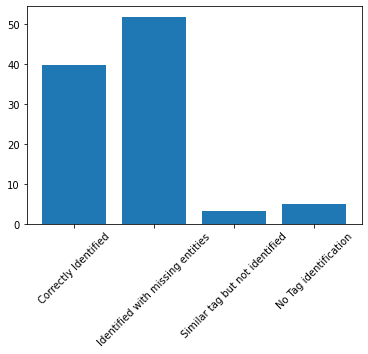

In [227]:
#!/usr/bin/python3
import matplotlib.pyplot as plt

data = [orig_asr_found_complete_per, orig_asr_found_per, orig_asr_similar_per, orig_asr_nofound_per]
plt.bar(['Correctly Identified', 'Identified with missing entities', 'Similar tag but not identified', 'No Tag identification'], data)
plt.xticks(rotation=45)
plt.show()

In [ ]:
orig_asr_similar.head(14)

In [ ]:
context_simulated_df = combined_df.loc[orig_asr_similar['Sample #'].values.tolist(),['original_sentence','original_tags']]

In [ ]:
context_simulated_df.head(30)

In [ ]:
g_test = df.groupby("Sentence #")
x = pd.DataFrame({"Sentence": g_test.apply(lambda sdf: " ".join(sdf.Word)),
                       "Tag": g_test.apply(lambda sdf: ",".join(sdf.Tag))})

In [ ]:
sentence_no = list(range(0, len(x)))

In [ ]:
x.index = sentence_no

In [ ]:
x.head()

In [ ]:
x.loc[context_simulated_df.index.tolist(), 'Sentence'] = context_simulated_df['original_sentence'].values.tolist()
x.loc[context_simulated_df.index.tolist(), 'Tag'] = context_simulated_df['original_tags'].values.tolist()

In [ ]:
x.head(18)

In [ ]:
asr_df.head()

In [ ]:
context_simulated_df.index.tolist()

In [ ]:
asr_df.loc[context_simulated_df.index.tolist(), 'Sentence'] = context_simulated_df['original_sentence'].values.tolist()
asr_df.loc[context_simulated_df.index.tolist(), 'Tag'] = context_simulated_df['original_tags'].values.tolist()

In [ ]:
asr_df.head(18)

In [ ]:
test_df = model_test(asr_df['Sentence'].values.tolist(), tokenizer, model)

In [ ]:
sentence_no = 0
dataset=[]
for sentences, tags in zip(x['Sentence'].values.tolist(), x['Tag'].values.tolist()):
    sentence=sentences.split(" ")
    tag = tags.split(",")
    for word, label in zip(sentence, tag):
        dataset.append((sentence_no, word, label))
    sentence_no = sentence_no + 1

In [ ]:
new_df = pd.DataFrame(dataset, columns=['Sentence #', 'Word', 'Tag'])

In [ ]:
new_df.head()

In [ ]:
test_df = prepare_model_output(test_df, new_df)

In [ ]:
test_df.tail()

In [ ]:
statistics(test_df, ['PER', 'ORG', 'LOC', 'O'])

In [ ]:
asr_df, combined_df = prepare_data_for_analysis(test_df, 'unprocessed_sampled_original.csv')

In [235]:
original = pd.read_csv('unprocessed_sampled_original.csv')
original.drop(['Unnamed: 0'], axis=1, inplace=True)
original = original[:7851]
g_original = original.groupby("Sentence #")
original_df = pd.DataFrame({'Sentence': g_original.apply(lambda sdf: " ".join(map(str,sdf.Word))),
                      'Tag': g_original.apply(lambda sdf: ",".join(sdf.Tag))})
original_df.reset_index(inplace=True)
combined_df = pd.DataFrame({"original_sentence": original_df['Sentence'],
                           "original_tags": original_df['Tag'], 
                           "asr_sentence": asr_df['Sentence'],
                           "asr_tags": asr_df['Tag']})

In [260]:
analysis_df = pd.DataFrame(pattern_finding("PER", combined_df), columns=['Sample #', 'Original', 'ASR', 'Lavenstein','Lavenstein Mean', 'Flag'])

In [261]:
analysis_df.head(10)

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,11,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
1,25,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
2,27,[Subiaco],[subiaco],[85.71428571428572],85.714286,True
3,37,[Chiswick],[Chiswick],[100.0],100.000000,False
4,49,[Society],[society],[85.71428571428572],85.714286,True
5,50,"[Chronicles, of, Newgate]","[None, None, NewNewgate]","[0.0, 0.0, 70.0]",23.333333,True
6,58,"[Court, of, Common, Council]","[None, None, common, Council]","[0.0, 0.0, 83.33333333333334, 100.0]",45.833333,True
7,59,"[House, of, Commons]","[House, of, Commons]","[100.0, 100.0, 100.0]",100.000000,True
8,62,"[State, of, Prisons]","[state, of, prisons]","[80.0, 100.0, 85.71428571428572]",88.571429,False
9,72,"[Court, Baron, Hundred, Court, County, Court]","[Court, None, Hundred, Court, county, Court]","[100.0, 0.0, 100.0, 100.0, 83.33333333333334, 100.0]",80.555556,True


In [262]:
len(analysis_df)

125

In [263]:
len(combined_df)

376

In [264]:
orig_asr_found_complete = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] == 100.0)]
orig_asr_found_complete_per = (len(orig_asr_found_complete) / len(analysis_df)) * 100
print(orig_asr_found_complete_per)
orig_asr_found_complete.head()
print(len(orig_asr_found_complete))

15.2
19


In [265]:
orig_asr_found = analysis_df[(analysis_df['Flag'] == True) & (analysis_df['Lavenstein Mean'] < 100.0) & (analysis_df['Lavenstein Mean'] >= 0.0)]
orig_asr_found_per = (len(orig_asr_found) / len(analysis_df)) * 100
print(orig_asr_found_per)
print(len(orig_asr_found))
orig_asr_found.head()
#40.88050314465409
#65

49.6
62


,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
2,27,[Subiaco],[subiaco],[85.71428571428572],85.714286,True
4,49,[Society],[society],[85.71428571428572],85.714286,True
5,50,"[Chronicles, of, Newgate]","[None, None, NewNewgate]","[0.0, 0.0, 70.0]",23.333333,True
6,58,"[Court, of, Common, Council]","[None, None, common, Council]","[0.0, 0.0, 83.33333333333334, 100.0]",45.833333,True
9,72,"[Court, Baron, Hundred, Court, County, Court]","[Court, None, Hundred, Court, county, Court]","[100.0, 0.0, 100.0, 100.0, 83.33333333333334, 100.0]",80.555556,True


In [266]:
orig_asr_similar = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 100.0) & (analysis_df['Lavenstein Mean'] > 0.0)]
orig_asr_similar_per = (len(orig_asr_similar) / len(analysis_df)) * 100
print(orig_asr_similar_per)
orig_asr_similar.head()
print(len(orig_asr_similar))

32.0
40


In [267]:
orig_asr_similar.head()

,Sample #,Original,ASR,Lavenstein,Lavenstein Mean,Flag
0,11,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
1,25,[Subiaco],[subiaco],[85.71428571428572],85.714286,False
3,37,[Chiswick],[Chiswick],[100.0],100.000000,False
8,62,"[State, of, Prisons]","[state, of, prisons]","[80.0, 100.0, 85.71428571428572]",88.571429,False
13,76,"[Courts, of, Requests, Courts, of, Conscience, of]","[Courts, of, Requests, Courts, of, conscience, of]","[100.0, 100.0, 100.0, 100.0, 100.0, 90.0, 100.0]",98.571429,False


In [268]:
len(orig_asr_similar)

40

In [269]:
orig_asr_nofound = analysis_df[(analysis_df['Flag'] == False) & (analysis_df['Lavenstein Mean'] <= 0.0)]
orig_asr_nofound_per = (len(orig_asr_nofound) / len(analysis_df))*100
print(orig_asr_nofound_per)
orig_asr_nofound.head()
print(len(orig_asr_nofound))

3.2
4


In [270]:
[orig_asr_found_complete_per, orig_asr_found_per, orig_asr_similar_per, orig_asr_nofound_per]

[15.2, 49.6, 32.0, 3.2]

In [271]:
[len(orig_asr_found_complete), len(orig_asr_found), len(orig_asr_similar), len(orig_asr_nofound)]

[19, 62, 40, 4]

In [228]:
def finding_context(df, n_grams):
    check = []
    for sample, original_sentence, asr_sentence, original_tag, asr_tag in zip(
                df.index,
                df['original_sentence'].values.tolist(),
                df['asr_sentence'].values.tolist(),
                df['Original'].values.tolist(),
                df['ASR'].values.tolist()):

        original_label = np.array(original_sentence.split())
        asr_label = np.array(asr_sentence.split())
        original_tag_ind = [index for index, element in enumerate(original_label) if original_label[index] in original_tag]
        asr_tag_ind = [index for index, element in enumerate(asr_label) if asr_label[index] in asr_tag]
        original_bigrams = []
        asr_bigrams = []
        for l in original_tag_ind:
            if l <= (len(original_label)-1) - n_grams:
                data = ""
                for c in range(-n_grams, n_grams+1, 1):
                    if l+c >= 0:
                        data = data + original_label[l + c] + " "
                    else:
                        continue
                original_bigrams.append(data)
            else:
                data = ""
                for c in range(-n_grams, 1, 1):
                    if l+c < len(original_label):
                        data = data + original_label[l + c] + " "
                    else:
                        continue
                original_bigrams.append(data)
        for l in asr_tag_ind:
            if l <= (len(asr_label) - 1) - n_grams:
                data = ""
                for c in range(-n_grams, n_grams + 1, 1):
                    if l + c >= 0:
                        data = data + asr_label[l + c] + " "
                    else:
                        continue
                asr_bigrams.append(data)
            else:
                data = ""
                for c in range(-n_grams, 1, 1):
                    if l + c < len(asr_label):
                        data = data + asr_label[l + c] + " "
                    else:
                        continue
                asr_bigrams.append(data)
        check.append((sample, (" | ").join(original_bigrams), original_sentence, original_tag, (" | ").join(asr_bigrams), asr_sentence, asr_tag))
    context = pd.DataFrame(check)
    context.columns = ['Sample #', 'Original N-Grams', "original_sentence", "Original", "ASR N-Grams", "asr_sentence", "ASR"]
    return context

In [229]:
def error_sampling3(context):
    check = []
    for sample, original_ngrams, original_sentence, asr_ngrams, asr_sentence, original_tag, asr_tag in zip(
            context['Sample #'].values.tolist(),
            context['Original N-Grams'].values.tolist(),
            context['original_sentence'].values.tolist(),
            context['ASR N-Grams'].values.tolist(),
            context['asr_sentence'].values.tolist(),
            context['Original'].values.tolist(),
            context['ASR'].values.tolist()):

        original_ngrams = np.array(original_ngrams.split("|"))
        asr_ngrams = np.array(asr_ngrams.split("|"))

        local_errors = []
        i = 0
        j = 0
        for _original in original_tag:
            if _original in asr_tag:
                if len(asr_ngrams) < len(asr_tag):
                    continue
                
                print(asr_sentence)
                asr_sentence = asr_sentence.replace("".join(asr_ngrams[i].rstrip()), "".join(original_ngrams[i].rstrip()))
                print(asr_sentence)
                #print(check)
                i = i + 1
                j = j + 1
            else:
                j = j + 1
        check.append((sample, asr_sentence))
        print("---------------")
    new_asr = pd.DataFrame(check)
    return new_asr

In [230]:
context = finding_context(equal_length_words_samples_df, 5)

In [231]:
context.head()

,Sample #,Original N-Grams,original_sentence,Original,ASR N-Grams,asr_sentence,ASR
0,11,like the transition type of Subiaco,"It must be said that it is in no way like the transition type of Subiaco ,",[Subiaco],like the transition type of subiaco,it must be said that it is in no way like the transition type of subiaco,[subiaco]
1,25,", like that of the Subiaco works , are of a","many of whose types , indeed , like that of the Subiaco works , are of a transitional character .",[Subiaco],indeed like that of the subiaco works are of a transitional,many of whose types indeed like that of the subiaco works are of a transitional character,[subiaco]
2,27,of the before - mentioned Subiaco,In fact Gunther Zeiner ' s first type ( afterwards used by Schussler ) is remarkably like the type of the before - mentioned Subiaco books .,[Subiaco],type of the before mentioned subiaco,in fact Gunther ' s designers first type afterwards used by schussler is remarkably like the type of the before mentioned subiaco books,[subiaco]
3,37,The Chiswick press in 1844 revived Caslon,"The Chiswick press in 1844 revived Caslon ' s founts , printing for Messrs . Longman the Diary of Lady Willoughby .",[Chiswick],Chiswick press in 1844 revived Castle,Chiswick press in 1844 revived Castle on stops printing for measures the Diary of Lady Willoughby,[Chiswick]
4,49,the position of our Society that a work of utility,"the position of our Society that a work of utility might be also a work of art , if we cared to make it so .",[Society],the position of our society that don ' t work,the position of our society that don ' t work of utility might be also a work of art if we care to make it so,[society]


In [232]:
simulated_asr_df = error_sampling3(context)
simulated_asr_df.head(50)

---------------
---------------
---------------
Chiswick press in 1844 revived Castle on stops printing for measures the Diary of Lady Willoughby
The Chiswick press in 1844 revived Caslon on stops printing for measures the Diary of Lady Willoughby
---------------
---------------
The Chronicles of nougat volume to Arthur Griffiths section for new NewNewgate down to 1818
The Chronicles of Newgate , Volume 2 Griffiths section for new NewNewgate down to 1818
The Chronicles of Newgate , Volume 2 Griffiths section for new NewNewgate down to 1818
The Chronicles of Newgate , Volume 2 Griffiths section for new NewNewgate down to 1818
---------------
full details of the arrangements are to be found in Mr Neil ' s state of prisons in England Scotland and Wales published in 1812
Full details of the arrangements are to be found in Mr Neil ' s state of prisons in England Scotland and Wales published in 1812
---------------
Alfred the Great established the court Baron the hundred court and the county

,0,1
0,11,it must be said that it is in no way like the transition type of subiaco
1,25,many of whose types indeed like that of the subiaco works are of a transitional character
2,27,in fact Gunther ' s designers first type afterwards used by schussler is remarkably like the type of the before mentioned subiaco books
3,37,The Chiswick press in 1844 revived Caslon on stops printing for measures the Diary of Lady Willoughby
4,49,the position of our society that don ' t work of utility might be also a work of art if we care to make it so
5,50,"The Chronicles of Newgate , Volume 2 Griffiths section for new NewNewgate down to 1818"
6,62,Full details of the arrangements are to be found in Mr Neil ' s state of prisons in England Scotland and Wales published in 1812
7,72,"Alfred the Great established the Court Baron , the Hundred Court the county court which among other matters entertain please for debt"
8,75,"so much inconvenience , that in 1518 the Corporation obtained from Parliament an act empowering to alderman"
9,76,"four common councilmen to hold Courts of Requests , or Courts conscience to hear and determine all causes of death"


In [233]:
asr_df = update_df(asr_df, simulated_asr_df)

In [ ]:
#context = finding_context(variable_length_words_samples_df, 5)

In [ ]:
#simulated_asr_df = error_sampling3(context)
#simulated_asr_df.head(50)

In [ ]:
#asr_df = update_df(asr_df, simulated_asr_df)

In [234]:
asr_df.head()

,Sentence,Tag,asr_sentence_no
0,for although the Chinese took Impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands by a similar process,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O",0
1,what the first Bible actually dated which also was printed at mace by Peter Shaffer in the year 1462,"O,O,O,O,O,O,O,O,O,O,O,O,O,PER,PER,O,O,O,O",1
2,especially as regards to lowercase letters and type very similar was used during the next 15 or 20 years not only by Schoeffer,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,PER",2
3,Buy printers in Strasburg basil Paris Lubec and other cities,"O,O,O,LOC,O,LOC,ORG,O,O,O",3
4,but don ' t expect in Italy letter with most often used,"O,O,O,O,O,O,LOC,O,O,O,O,O",4


In [ ]:
test = ["and though the famous family of aldus restored its technical excellence , rejecting battered letters ,","most of caxton ' s zone types of an earlier character", "are the leaders in this luckless change , though our own baskerville , who was at work some years before them , went much on the same lines",
       "now come into general use that are obviously a great improvement on the ordinary \" modern style \" and use in england , which is in fact the bodoni type" , "on the top of the jail , continues neild , arawatch - house and a century - box , where two or more guards , with dogs and firearms ," ,
       "these courts were extended to centuries later to several large provincial towns , and all were in full activity when neild road ," , "he had been in the employ of a corn - chandler at islington , and went into london with his master ' s cart and horse .",
       "shameful malpractices of bambridge ," , "if they happened to be in funds - - among whom was the marquis of slego in 1811", 
       "mister . neild , a second howard ,", "again the 22 charles ii . c20 order the jailer to keep felons and debtors \" separate and apart from one another ,",
       "prisoners were crowded together in the jail , contrary to the requirements of the for george the 4th ."]

In [ ]:
test = "have now come into general use and are obviously a great improvement on the ordinary \" modern style \" in use in england , which is in fact the bodoni type"

In [ ]:
xyz = model_test([test], tokenizer, model)

In [ ]:
xyz